# Loading dependencies + data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import figs

import sys
sys.path.append('..')
import lb

%load_ext autoreload
%autoreload 2


In [2]:
figs.set_mpl_style()


In [3]:
Dall = lb.exp.Data.load('0.4')
D = Dall.qualified()


Large difference 83ms between duration 26914ms and end-start difference 26831ms for pid=md5:8c43bec3733bb9976c197bff02dbf4e2 trial=3
Large difference 155ms between duration 6858ms and end-start difference 6703ms for pid=md5:fce1be10fd7e4f749e9b5f731056d7f3 trial=4
Modal row count 34. # matching 193 / 235
# with no programming 171 / 235
# valid workers 171 / 235


# Descriptive: general

In [4]:
Dall.report_programming_experience()


Large difference 83ms between duration 26914ms and end-start difference 26831ms for pid=md5:8c43bec3733bb9976c197bff02dbf4e2 trial=3
Large difference 155ms between duration 6858ms and end-start difference 6703ms for pid=md5:fce1be10fd7e4f749e9b5f731056d7f3 trial=4

193 workers completed task

Have you played Lightbot or another similar programming game before?
No | 189/193 98%
Yes | 4/193 2%

How much experience do you have with computer programming?
Between 1 and 3 college courses (or equivalent) | 46/193 24%
More than 3 college courses (or equivalent) | 22/193 11%
None | 125/193 65%



# Enumerating programs

In [5]:
if 'dc' in locals():
    del dc
    import gc
    gc.collect()

dc = lb.fitting.default_program_enumeration(D)


Loading from cached file took 40.99 seconds. Last modified 2023-11-21T15:13:51.996548+00:00 (1:20:49.283764 ago)


In [6]:
dc.show()


--------------------
('cgcMaps', 14) 39650 elapsed {'enum:trace': '0.293s', 'enum:program': '0.899s', 'enum:program_count_matrix': '1.528s'}
Behavior #participants=166 trace range=12-40 perc(50=14.00, 75=15.75, 95=18.75, 99=22.70)
TraceSet #1124 #programs=39650 trace range 12-20 iters=19615 non-monotonic=0
trace (full) missing total=4/166 (2.41%) unique=4/31 (12.90%) avg count per unique=4/4=1.00 {'BDCAEBDCAEBBECCCECCECA', 'DCCEBBAECBACEECEBBECECCCEBCCEBBECCEBBECA', 'EBDCDBCAEBDCAEBECCBECECA', 'BBADDBECADDCDBBDCDBECA'}
trace (by 2+) missing total=0/150 (0.00%) unique=0/15 (0.00%)  set()
program (full) missing total=15/166 (9.04%) unique=15/69 (21.74%) avg count per unique=15/15=1.00
program (by 2+) missing total=0/121 (0.00%) unique=0/24 (0.00%) 
Participant % with trace within max length 97.59% (assuming astar with include_equal_score)

--------------------
('cgcMaps', 3) 6742493 elapsed {'enum:trace': '1.980s', 'enum:program': '197.323s', 'enum:program_count_matrix': '387.640s'}
Beha

# Descriptive: Most common programs

In [7]:
ct = dict(sum=0, total=0)
ct_2plus = dict(sum=0, total=0)

for row in dc.d:
    for p, ct_ in row.bs.program_counts.items():
        found = p in row.ts.programs
        if found:
            ct['sum'] += ct_
            if ct_ >= 2: ct_2plus['sum'] += ct_
        ct['total'] += ct_
        if ct_ >= 2: ct_2plus['total'] += ct_

print(f"Percentage of participant programs found: {ct['sum'] / ct['total'] * 100:.0f}")
print(f"Percentage of participant programs found (2+): {ct_2plus['sum'] / ct_2plus['total'] * 100:.0f}")


Percentage of participant programs found: 78
Percentage of participant programs found (2+): 94


# Plot cross-MDP BICs

In [9]:
# First, fit models
fit_models = lb.fitting.analysis(dc)


Loading from cached file took 0.00 seconds. Last modified 2023-11-21T15:13:51.619429+00:00 (1:23:37.779156 ago)
score_reuse_and_reward FitResult(range=[12825.23, 12825.23], success=5/5, best_params=Args(b=2.5248595286027005, prior_beta=0.37858641800686266, p_normal=0.906770306905533, step_count_coef=0.516005655900752), elapsed_sec_range=[1702.45, 2966.03])
score_reuse FitResult(range=[13482.30, 13482.30], success=5/5, best_params=Args(b=4.229817761725173, prior_beta=0.48215074815460035, p_normal=0.8762710916834536), elapsed_sec_range=[1226.27, 1880.67])
score_mdl_and_reward FitResult(range=[15267.23, 15267.23], success=5/5, best_params=Args(mdl_beta=0.5252788482574894, step_count_coef=0.8516355679429073), elapsed_sec_range=[19.12, 29.08])
score_mdl FitResult(range=[16787.27, 16787.27], success=5/5, best_params=Args(mdl_beta=0.978015535178402), elapsed_sec_range=[5.99, 8.35])
score_reward FitResult(range=[15880.54, 15880.54], success=5/5, best_params=Args(step_count_coef=1.3073341827748

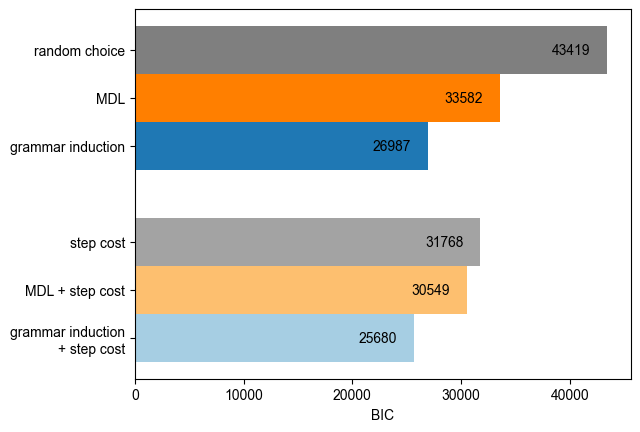

In [10]:
dd = pd.DataFrame([
    {
        'Model': m.name,
        'BIC': fit_models[m.score_key].bic,
        'step-cost': 'reward' in m.score_key,
        'color': m.color,
    }
    for m in figs.models.all
])

f, ax = plt.subplots()
width = 0.25

ticks = []
for group_idx, (_, rows) in enumerate(dd.groupby('step-cost')):
    for idx, row in enumerate(rows.itertuples()):
        pos = group_idx + idx * width
        r = ax.barh(pos, row.BIC, width, color=row.color)
        ax.bar_label(r, padding=-40, color='black', fmt='%.0f')
        ticks.append((pos, row.Model.replace('grammar induction +', 'grammar induction\n+')))

ax.set_yticks(*zip(*ticks))
plt.xlabel('BIC')
plt.ylim(*plt.ylim()[::-1])

figs.save('model-programs-across.pdf')


In [11]:
def lrt_latex(fit_models, hyp, null, dof_difference, *, show=False):
    hyp_m = fit_models[hyp.score_key]
    null_m = fit_models[null.score_key]
    p = hyp_m.likelihood_ratio_test(null_m)

    # # For logging param differences. For debugging
    # hyp_params = set(hyp.result['final_args'].free_parameters)
    # null_params = set(null.result['final_args'].free_parameters)
    # print(hyp_params - null_params)

    # We're repeating this here as validation
    from scipy.stats.distributions import chi2
    assert hyp_m.dof - null_m.dof == dof_difference, (hyp_m.dof, null_m.dof, dof_difference)
    LR = 2 * (hyp_m.log_likelihood - null_m.log_likelihood)
    p2 = chi2.sf(LR, dof_difference)
    assert np.isclose(p, p2)

    # Return a tuple for now
    rv = f'$\chi^2({dof_difference})={LR:.1f}$', f'${figs.pvalue(p)}$'
    if show:
        print(', '.join((hyp.name, null.name) + rv))
    return rv

lrt_latex(fit_models, figs.models.reward, figs.models.null, 1, show=True)
lrt_latex(fit_models, figs.models.mdl, figs.models.null, 1, show=True)
lrt_latex(fit_models, figs.models.reuse, figs.models.null, 3, show=True)
print()
lrt_latex(fit_models, figs.models.mdl_and_reward, figs.models.reward, 1, show=True)
lrt_latex(fit_models, figs.models.reuse_and_reward, figs.models.reward, 3, show=True)
None


step cost, random choice, $\chi^2(1)=11658.3$, $p < .001$
MDL, random choice, $\chi^2(1)=9844.8$, $p < .001$
grammar induction, random choice, $\chi^2(3)=16454.7$, $p < .001$

MDL + step cost, step cost, $\chi^2(1)=1226.6$, $p < .001$
grammar induction + step cost, step cost, $\chi^2(3)=6110.6$, $p < .001$


# Plot single-MDP BICs

In [12]:
# Load above analysis
fit_models = lb.fitting.analysis(dc)

def per_task_bic(fit_models, m):
    print()
    print('Computing per-task BIC for', m.score_key)

    fit = fit_models[m.score_key]
    a = fit.result['final_args']

    def original_fn(res, a):
        return res.ts.crossent(res.bs, a, batch_score=m.batch_score_fn)

    if 'grammar induction' in m.name:
        print('Because this includes the reuse model, integrating nuisance parameters out.')
        # HACK These nuisance_params are copy/pasted from model fitting.
        nuisance_params = dict(p_end=np.linspace(0.1, 0.9, 9))
        fn = lambda res, outer_a: lb.fitting.integrate_nuisance_for_negative_log_fn(lambda a: original_fn(res, a), outer_a, nuisance_params)
    else:
        nuisance_params = None
        fn = original_fn

    lls = np.array([
        -fn(res, a)
        for res in dc.d
    ])
    # They will differ only in the case of nuisance parameter integration.
    print(f'Log probability of data, summed across tasks: {np.sum(lls):.2f}. Log probability of entire dataset: {fit.log_likelihood:.2f}.')
    if nuisance_params is None:
        assert np.isclose(np.sum(lls), fit.log_likelihood), (np.sum(lls), fit.log_likelihood)

    obs_counts = np.array([
        sum(res.bs.program_counts.values())
        for res in dc.d
    ])
    assert np.sum(obs_counts) == fit.observation_count, (np.sum(obs_counts), fit.observation_count)

    bics = fit.dof * np.log(obs_counts) - 2 * lls

    return pd.DataFrame(dict(bic=bics, ll=lls, obs_count=obs_counts))

model_bics = {
    m.score_key: per_task_bic(fit_models, m)
    for m in figs.models.all
}


Loading from cached file took 0.00 seconds. Last modified 2023-11-21T15:13:51.619429+00:00 (1:23:50.107721 ago)
score_reuse_and_reward FitResult(range=[12825.23, 12825.23], success=5/5, best_params=Args(b=2.5248595286027005, prior_beta=0.37858641800686266, p_normal=0.906770306905533, step_count_coef=0.516005655900752), elapsed_sec_range=[1702.45, 2966.03])
score_reuse FitResult(range=[13482.30, 13482.30], success=5/5, best_params=Args(b=4.229817761725173, prior_beta=0.48215074815460035, p_normal=0.8762710916834536), elapsed_sec_range=[1226.27, 1880.67])
score_mdl_and_reward FitResult(range=[15267.23, 15267.23], success=5/5, best_params=Args(mdl_beta=0.5252788482574894, step_count_coef=0.8516355679429073), elapsed_sec_range=[19.12, 29.08])
score_mdl FitResult(range=[16787.27, 16787.27], success=5/5, best_params=Args(mdl_beta=0.978015535178402), elapsed_sec_range=[5.99, 8.35])
score_reward FitResult(range=[15880.54, 15880.54], success=5/5, best_params=Args(step_count_coef=1.3073341827748

In [18]:
df = pd.DataFrame([
    {
        'Model': m.name_label,
        'mdp_name': res.mdp_name,
        'MDP': chr(ord('a') + idx), # Map from 0-N to a-?
        'BIC': model_bics[m.score_key].bic[idx],
        'Log_Likelihood': model_bics[m.score_key].ll[idx],
        'step-cost': 'reward' in m.key,
    }
    for m in figs.models.all
    for idx, res in enumerate(dc.d)
])


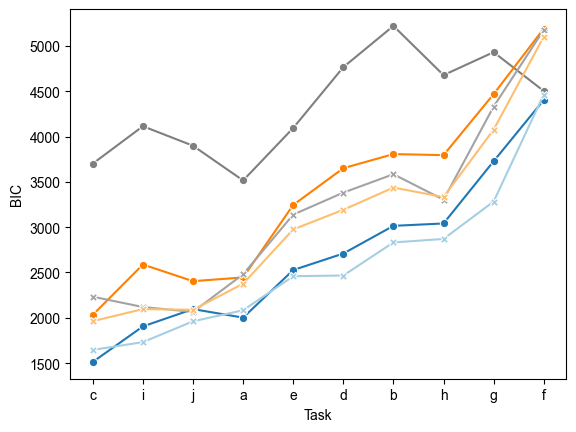

In [19]:
rc_df = df[df.Model=='grammar induction\n+ step cost']
task_order = rc_df.iloc[rc_df.BIC.argsort()].MDP
df2 = df.copy()
# https://stackoverflow.com/questions/62630875/how-to-change-the-plot-order-of-the-categorical-x-axis
df2['MDP'] = pd.Categorical(df['MDP'], categories=task_order, ordered=True)

sns.lineplot(
    x='MDP', y='BIC', hue='Model',
    data=df2,
    style='step-cost',
    markers=True, dashes=False,
    palette=[m.color for m in figs.models.all])
plt.xlabel('Task')
plt.gca().get_legend().remove()

figs.save('model-programs-between.pdf')


# Parameter table

In [20]:
def makecell(s):
    return r'\makecell{' + s + '}'

param_label = dict(
    step_count_coef=r'$\beta_{\text{StepCost}}$',
    prior_beta=r'$\beta_{\text{GrammarInduction}}$',
    mdl_beta=r'$\beta_{\text{MDL}}$',
    b=r'$\alpha$',
    p_end=r'$p_{end}$',
    p_normal=r'$p_{call}$',
)

rows = []

for model in figs.models.all:
    name = model.score_key
    fit = fit_models[name]
    fit_args = fit.result['final_args']

    args = list(fit_args.free_parameters.keys())
    assert len(args) == fit.dof
    for a in args:
        fi = lb.fitting.Args.field_info[a]
        extra_msg = ''
        assert a in fit_args.free_parameters
        value = getattr(fit_args, a)
        if a == 'p_normal':
            assert fit_args.free_parameters[a] == 1/2
            assert fi.bounds == lb.fitting.BoundTypes.prob
            value = 1 - value # HACK We need to subtract from 1 b/c we call this a p(call) in the text
        else:
            assert fit_args.free_parameters[a] == 1, 'Ensuring all started at same'
            assert fi.bounds in (lb.fitting.BoundTypes.pos, lb.fitting.BoundTypes.pos_w0)
            if fi.bounds == lb.fitting.BoundTypes.pos_w0:
                print(f'WARNING: Argument {a} has bounds that permit 0 as a value, make sure to note if relevant')
        rows.append({
            'Model': model.name,
            'Parameter': param_label[a],
            'Fitted Value': f'{value:.2f}{extra_msg}',
        })


In [21]:
print(pd.DataFrame(rows).set_index(['Model', 'Parameter']).to_latex(escape=False))


\begin{tabular}{lll}
\toprule
                              &                           & Fitted Value \\
Model & Parameter &              \\
\midrule
MDL & $\beta_{\text{MDL}}$ &         0.98 \\
grammar induction & $\alpha$ &         4.23 \\
                              & $\beta_{\text{GrammarInduction}}$ &         0.48 \\
                              & $p_{call}$ &         0.12 \\
step cost & $\beta_{\text{StepCost}}$ &         1.31 \\
MDL + step cost & $\beta_{\text{MDL}}$ &         0.53 \\
                              & $\beta_{\text{StepCost}}$ &         0.85 \\
grammar induction + step cost & $\alpha$ &         2.52 \\
                              & $\beta_{\text{GrammarInduction}}$ &         0.38 \\
                              & $p_{call}$ &         0.09 \\
                              & $\beta_{\text{StepCost}}$ &         0.52 \\
\bottomrule
\end{tabular}



# Are common programs easier to write?

--------------------
Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: update(fml, . ~ . + prog_count)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2600.8   2638.8  -1293.4   2586.8     1661 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1993 -0.6338 -0.0560  0.5200  4.5994 

Random effects:
 Groups   Name        Variance Std.Dev.
 pid      (Intercept) 0.22718  0.4766  
 mdp_name (Intercept) 0.08795  0.2966  
 Residual             0.20982  0.4581  
Number of obs: 1668, groups:  pid, 171; mdp_name, 10

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  4.774e+00  1.408e-01  4.409e+01  33.917  < 2e-16 ***
cost         1.040e-02  4.579e-03  1.444e+03   2.270   0.0233 *  
hier_len     2.147e-02  4.089e-03  1.664e+03   5.252  1.7e-07 ***
prog_count  -8.098e-03  9.594e-04  1.542e+03  -8.441  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 

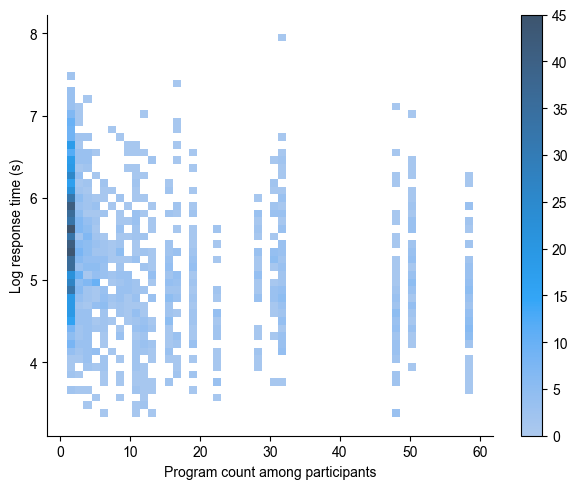

anova $\chi^2(1)=69.73$, $p < .001$
--------------------
Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: update(fml, . ~ . + prog_count)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 11323.3  11361.2  -5654.7  11309.3     1661 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2484 -0.5322 -0.1173  0.3148  9.7397 

Random effects:
 Groups   Name        Variance Std.Dev.
 pid      (Intercept) 29.947   5.472   
 mdp_name (Intercept)  1.183   1.087   
 Residual             41.213   6.420   
Number of obs: 1668, groups:  pid, 171; mdp_name, 10

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   -0.22232    1.25149   71.45893  -0.178     0.86    
cost           0.23241    0.05675  245.27940   4.095 5.73e-05 ***
hier_len       0.30274    0.05533 1567.03844   5.471 5.20e-08 ***
prog_count    -0.05251    0.01286  760.20460  -4.085 4.88e-05 ***
---
Signif. codes

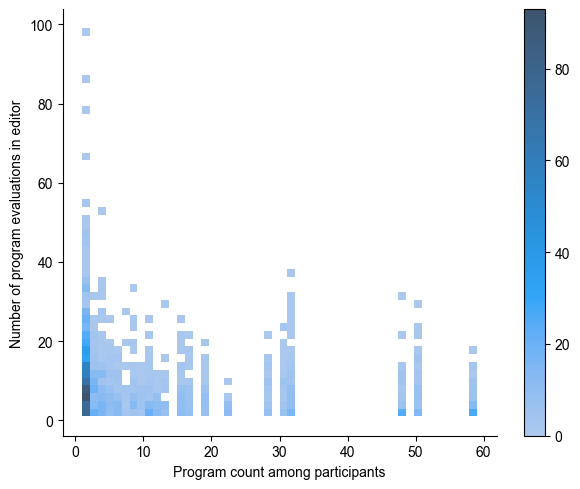

anova $\chi^2(1)=16.48$, $p < .001$


In [22]:
rows = []
cts = D.programs_by_count()
for participant in D.participants:
    for tr in participant.task_rows():
        if tr.skipped:
            continue
        rows.append(dict(
            pid=participant.worker,
            mdp_name='-'.join(map(str, tr.mdp_name)),
            log_elapsed_seconds=np.log(tr.elapsed_minutes * 60),
            runs=len(tr.editor_runs()),
            prog_count=cts[tr.mdp_name][tr.canonical_program],
            cost=lb.ProgramStepCounter.count(tr.mdp, tr.program).step,
            hier_len=lb.hier_len(tr.program),
        ))
rows = pd.DataFrame(rows)

label = {
    'prog_count': 'Program count among participants',
    'log_elapsed_seconds': 'Log response time (s)',
    'runs': 'Number of program evaluations in editor',
}

for x, y in [
    ('prog_count', 'log_elapsed_seconds'),
    ('prog_count', 'runs'),
]:
    print('-' * 20)
    import journal.figs as figs
    model_null, model = figs.runr(f'''
    library(lme4)
    library(lmerTest)
    fml = {y} ~ (1|pid) + (1|mdp_name) + cost + hier_len
    null = lmer(fml, data=df, REML=FALSE)
    m = lmer(update(fml, . ~ . + {x}), data=df, REML=FALSE)
    show(summary(m))
    show(anova(null, m))
    list(null, m)
    ''', df=figs.convert_df_to_rdf(rows))
    sns.displot(x=x, y=y, data=rows, cbar=True, bins=50, aspect=1.25)
    plt.xlabel(label[x])
    plt.ylabel(label[y])
    figs.save(f'program-ease-{x}-{y}.pdf')
    plt.show()
    figs.anova(model=model, null=model_null)
